In [2]:
# Import packages needed to gather, clean, 
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import glob
import re
from config import *

## Gathering Data
* Import the weratedogs csv file into a dataframe

* Download udacity image predictor file from the the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

* Create a json file containing each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

In [3]:
# Pull in the twitter-archive-enhanced csv file downloaded from the udacity site.
df_ta = pd.read_csv('twitter-archive-enhanced.csv')
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
# Create a request to pull the image predictions tsv file from the udacity site. Take the image predictions file thats stored in
# check response status to ensure we don't have an error.
# the response output and open a tsv file to hold the data so it can be called later.
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
r.raise_for_status()

with open('image_predictions.tsv', 'wb') as handle:
    for block in r.iter_content(1024):
        handle.write(block)

In [5]:
# Create dataframe for the image predictions file just downloaded
df_pred = pd.read_csv('image_predictions.tsv', sep='\t')

In [9]:
# Pull information on tweets using twitter api
# Pause loop to allow refresh of data pulling
# print twitter json data to file (tweet_json.txt)

auth = tweepy.OAuthHandler(consumer_token, consumer_token_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
df_error = []
with open('tweet_json.txt', 'w') as append:
    for index, row in df_ta.iterrows():
            try:
                tweet = api.get_status(row['tweet_id'], )
                json.dump(tweet._json, append)
                append.write('\n')
            except tweepy.TweepError as e:
                df_error.append({'tweet_id': row['tweet_id'], 'Error': (e.args[0][0]['code'], e.args[0][0]['message'])})
                pass
            
df_error = pd.DataFrame(df_error, columns = ['tweet_id', 'Error'])
df_error.to_csv('df_error.csv')

Rate limit reached. Sleeping for: 670
Rate limit reached. Sleeping for: 732


In [6]:
# Loop through tweet_json file and extract the tweeet_id, retweet_count, favorite_count from the tweet_json.txt file created
# in the previous step.
df_tweet_likes = []
tweet_file = open('tweet_json.txt')
for line in tweet_file:
    data = json.loads(line)
    tweet_id = data['id']
    retweet_count = data['retweet_count']
    favorite_count = data['favorite_count']
    df_tweet_likes.append({'tweet_id' : tweet_id
                          ,'favorite_count' : favorite_count
                          ,'retweet_count' : retweet_count})

df_tweet_likes = pd.DataFrame(df_tweet_likes, columns = ['tweet_id', 'favorite_count', 'retweet_count'])

In [7]:
# See how many likes you pulled. Compare to df_ta file.
print('There are {} records in the df_tweet_likes, compared to {} records in the df_ta.'.format(len(df_tweet_likes), len(df_ta)))

There are 2340 records in the df_tweet_likes, compared to 2356 records in the df_ta.


So we are missing 14 records between the two dataframes. I am sure this will change during the clean up step when I remove some of the retweets.

## Assess Data

In this section we will assess the data for quality and tidiness issues as outlined below.

#### Quality
Review each table and find the quality issues
i.e. Data formats, typos, data inconsistencies (abbr vs. full length), missing information, missing records

#### Tidiness
Breaking apart data in columns (email/phone), dog classification(pupper, doggo, ect), table structure

In [8]:
# Pull the info on the df_ta file and determine what kind of data types we are dealing with.
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

From this we can tell that we have a few data types that need to be cleaned up. Such as the timestamp fields

In [9]:
# Pull the info on the df_pred dataframe and determine what kind of data types we are dealing with
df_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [10]:
df_tweet_likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null int64
favorite_count    2340 non-null int64
retweet_count     2340 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [11]:
# Run the df_error = pd.read_csv('df_error.csv') file to bring in the errors from the twitter api pull. If not running
# the twitter api pull yourself.
df_error = pd.read_csv('df_error.csv')

df_error.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
Unnamed: 0    16 non-null int64
tweet_id      16 non-null int64
Error         16 non-null object
dtypes: int64(2), object(1)
memory usage: 464.0+ bytes


In [12]:
# Review the table and see what needs to be cleaned up
df_ta.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [13]:
# Review and locate the number of incorrect names
sorted(df_ta.name.unique())

['Abby',
 'Ace',
 'Acro',
 'Adele',
 'Aiden',
 'Aja',
 'Akumi',
 'Al',
 'Albert',
 'Albus',
 'Aldrick',
 'Alejandro',
 'Alexander',
 'Alexanderson',
 'Alf',
 'Alfie',
 'Alfy',
 'Alice',
 'Amber',
 'Ambrose',
 'Amy',
 'Amélie',
 'Anakin',
 'Andru',
 'Andy',
 'Angel',
 'Anna',
 'Anthony',
 'Antony',
 'Apollo',
 'Aqua',
 'Archie',
 'Arlen',
 'Arlo',
 'Arnie',
 'Arnold',
 'Arya',
 'Ash',
 'Asher',
 'Ashleigh',
 'Aspen',
 'Astrid',
 'Atlas',
 'Atticus',
 'Aubie',
 'Augie',
 'Autumn',
 'Ava',
 'Axel',
 'Bailey',
 'Baloo',
 'Balto',
 'Banditt',
 'Banjo',
 'Barclay',
 'Barney',
 'Baron',
 'Barry',
 'Batdog',
 'Bauer',
 'Baxter',
 'Bayley',
 'BeBe',
 'Bear',
 'Beau',
 'Beckham',
 'Beebop',
 'Beemo',
 'Bell',
 'Bella',
 'Belle',
 'Ben',
 'Benedict',
 'Benji',
 'Benny',
 'Bentley',
 'Berb',
 'Berkeley',
 'Bernie',
 'Bert',
 'Bertson',
 'Betty',
 'Beya',
 'Biden',
 'Bilbo',
 'Billl',
 'Billy',
 'Binky',
 'Birf',
 'Bisquick',
 'Blakely',
 'Blanket',
 'Blipson',
 'Blitz',
 'Bloo',
 'Bloop',
 'Blu',


In [14]:
# Count the number of retweets
len(df_ta.retweeted_status_id.unique())

182

In [15]:
df_ta.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

In [16]:
df_ta.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2], dtype=int64)

In [17]:
len(df_ta.in_reply_to_status_id.unique())

78

In [18]:
len(df_ta.in_reply_to_user_id.unique())

32

In [19]:
df_tweet_likes.query('favorite_count == 0')

,tweet_id,favorite_count,retweet_count
31,886054160059072513,0,105
35,885311592912609280,0,18216
67,879130579576475649,0,6715
72,878404777348136964,0,1268
73,878316110768087041,0,6546
77,877611172832227328,0,80
90,874434818259525634,0,14553
95,873337748698140672,0,1570
106,871166179821445120,0,5674
120,868639477480148993,0,2100


#### Quality Issues
* timestamp not listed as datetime field `df_ta`
* remove retweets (182) `df_ta`
* remove tweets that had errors pulling data from twitter api `df_errors`, most likely due to a tweet or account being removed. (14)
* `df_tweet_likes` (166) without a favorite, yet when you visit the page you see they've been favorited.
* Source contains to much non-sense infomation, should be trimmed down to where the tweet came from. (iPhone, twitter, ect) `df_ta`
* Why so many 0 for favorite_count? Looking at data seems maybe from retweets? `df_tweet_likes`
* Dog name case on the `df_pred` table in columns p1, p2 and p3
* Multiple names not entered correctly (quite, such, a, not, O, just, an, a, all, actually, an, by, getting, his, incredibly, ect) `df_ta`

#### Tidy Issues

* Multiple tables `df_ta`, `df_errors`, `df_tweet_likes` and `df_pred`
* Multiple columns for dog rating (doggo, floofer, pupper, puppo) `df_ta`

## Cleaning

From this point forward we will create a copy of each of our dataframes so we can work on cleaning without overwritting our original files. We'll walk through each of our quality issues followed by our tidiness issues.

In [20]:
df_ta_clean = df_ta.copy()
df_tweet_likes_clean = df_tweet_likes.copy()
df_pred_clean = df_pred.copy()

## Quality Issues
### Define
1. timestamp no listed as a datetime field.

### Code

In [21]:
# Change the timestamp fields from object fields to datetime fields, using pandas to_datetime function.
df_ta_clean['timestamp'] = pd.to_datetime(df_ta_clean['timestamp'])
df_ta_clean['retweeted_status_timestamp'] = pd.to_datetime(df_ta_clean['retweeted_status_timestamp'])

### Test

In [22]:
# Review info to ensure the conversation was completed.
df_ta_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime

### Define
2. Remove Retweets using the Retweet status id looking for NaN

### Code

In [23]:
df_ta_clean = df_ta_clean.query('retweeted_status_id == "NaN"')
df_ta_clean = df_ta_clean.reset_index(drop=True)

### Test

In [24]:
df_ta_clean.query('in_reply_to_status_id != "NaN"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
29,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaT,NaN,12,10,None,None,None,None,None
52,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaT,NaN,17,10,None,None,None,None,None
61,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaT,NaN,14,10,None,None,None,None,None
101,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaT,NaN,10,10,None,None,None,None,None
130,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaT,NaN,12,10,None,None,None,None,None
131,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
156,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaT,NaN,12,10,None,None,None,None,None
159,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
160,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaT,NaN,14,10,None,None,None,None,None
162,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaT,NaN,420,10,None,None,None,None,None


### Define

3. Remove the tweets from the df_error file

### Code

In [76]:
for index, row in df_error.iterrows():
    check = row['tweet_id']
    df_ta_clean = df_ta_clean[df_ta_clean != check]

### Test

In [77]:
df_ta_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                      2173 non-null float64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[n

Looks like the errors where cleaned up during a previous step, my before and after counts are the same.

### Define

4. Remove the non-sense info from the source column to make more sense.

### Code

In [25]:
# Determine what type of sources the tweets were coming from
df_ta_clean['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [26]:
# Create a loop to replace the source file with the info between the tags
for index, row in df_ta_clean.iterrows():
    df_ta_clean['source'][index] = re.findall(r'>(.*)<', row['source'])[0]

C:\Users\ryanj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Test

In [80]:
# Check to see what values are in the source column after our loop
df_ta_clean['source'].unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

### Define
5. Dog type case and spacing on df_pred table all start lower case.

### Code

In [27]:
# Make the Dog Name Capitalized by using the title function
df_pred_clean['p1'] = df_pred_clean.p1.str.title()
df_pred_clean['p2'] = df_pred_clean.p2.str.title()
df_pred_clean['p3'] = df_pred_clean.p3.str.title()

In [28]:
# Remove the _ and replace with a space using the replace function
df_pred_clean['p1'].replace(regex=True,inplace=True,to_replace="_",value=r' ')
df_pred_clean['p2'].replace(regex=True,inplace=True,to_replace="_",value=r' ')
df_pred_clean['p3'].replace(regex=True,inplace=True,to_replace="_",value=r' ')

In [83]:
# If the predictor couldn't classify any as a dog then drop that row and only  return rows that have some prediction of a dog
df_pred_clean = df_pred_clean.query('p1_dog == True or p2_dog == True or p3_dog == True')

### Test

In [84]:
df_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1751 non-null int64
jpg_url     1751 non-null object
img_num     1751 non-null int64
p1          1751 non-null object
p1_conf     1751 non-null float64
p1_dog      1751 non-null bool
p2          1751 non-null object
p2_conf     1751 non-null float64
p2_dog      1751 non-null bool
p3          1751 non-null object
p3_conf     1751 non-null float64
p3_dog      1751 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 141.9+ KB


In [29]:
df_pred_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Define
6. Clean up the missing names in the `df_ta_clean` table

### Code

In [30]:
df_ta_clean['name'].groupby(df_ta_clean.name).size()

name
Abby             2
Ace              1
Acro             1
Adele            1
Aiden            1
Aja              1
Akumi            1
Al               1
Albert           2
Albus            2
Aldrick          1
Alejandro        1
Alexander        1
Alexanderson     1
Alf              1
Alfie            4
Alfy             1
Alice            2
Amber            1
Ambrose          1
Amy              1
Amélie           1
Anakin           1
Andru            1
Andy             1
Angel            1
Anna             1
Anthony          1
Antony           1
Apollo           1
                ..
Ziva             1
Zoe              1
Zoey             3
Zooey            1
Zuzu             1
a               55
actually         2
all              1
an               6
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             3
life             1
light            1
mad              1
my               1
not              2
officially       1
old    

We can see that we have a lot of bad names (55 with a name of 'a') we can remove these bad names and just make them null values.

In [31]:
df_ta_clean['name'] = df_ta_clean['name'].replace(to_replace = r'^([a-z])', value = np.nan, regex = True)

In [32]:
df_ta_clean['name'].groupby(df_ta_clean.name).size()

name
Abby            2
Ace             1
Acro            1
Adele           1
Aiden           1
Aja             1
Akumi           1
Al              1
Albert          2
Albus           2
Aldrick         1
Alejandro       1
Alexander       1
Alexanderson    1
Alf             1
Alfie           4
Alfy            1
Alice           2
Amber           1
Ambrose         1
Amy             1
Amélie          1
Anakin          1
Andru           1
Andy            1
Angel           1
Anna            1
Anthony         1
Antony          1
Apollo          1
               ..
Walker          1
Wallace         3
Wally           2
Walter          3
Watson          2
Wesley          1
Wiggles         1
Willem          1
William         1
Willie          1
Willow          1
Willy           1
Wilson          3
Winifred        1
Winnie          4
Winston         8
Wishes          1
Wyatt           3
Yoda            1
Yogi            2
Yukon           1
Zara            1
Zeek            1
Zeke            3
Zeus 

### Test

In [34]:
df_ta_clean['name'].isna().sum()

104

104 records have a null value now for name.

## Tidy Issues
### Define
1. doggo, floofer, pupper, puppo should be all one column

### Code

In [36]:
# melt the doggo, floofer, pupper, puppo columns into one dog_type column
df_ta_clean2 = pd.melt(df_ta_clean, id_vars = ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
                                    'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp',
                                    'expanded_urls', 'rating_numerator', 'rating_denominator', 'name'], value_vars = ['doggo', 'floofer', 'pupper', 'puppo'], var_name='stage', value_name='dog_type')

### Test

In [37]:
df_ta_clean2['dog_type'].value_counts()

None       8344
pupper      234
doggo        87
puppo        25
floofer      10
Name: dog_type, dtype: int64

In [38]:
# Bring back our df_ta_clean dataframe by copying our df_ta_clean2 dataframe
df_ta_clean = df_ta_clean2.copy()

In [39]:
# Drop the stage column as its not needed
df_ta_clean.drop(['stage'], axis=1, inplace=True)

In [41]:
# Check Column Count
df_ta_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 14 columns):
tweet_id                      8700 non-null int64
in_reply_to_status_id         312 non-null float64
in_reply_to_user_id           312 non-null float64
timestamp                     8700 non-null datetime64[ns]
source                        8700 non-null object
text                          8700 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 8468 non-null object
rating_numerator              8700 non-null int64
rating_denominator            8700 non-null int64
name                          8284 non-null object
dog_type                      8700 non-null object
dtypes: datetime64[ns](2), float64(4), int64(3), object(5)
memory usage: 951.6+ KB


In [42]:
# Remove duplicate columns as the dog_type melt created duplicates
df_ta_clean = df_ta_clean.sort_values('dog_type').drop_duplicates('tweet_id', keep = 'last')

In [44]:
# now back to our orginal 2175 rows
df_ta_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 2095 to 7298
Data columns (total 14 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2071 non-null object
dog_type                      2175 non-null object
dtypes: datetime64[ns](2), float64(4), int64(3), object(5)
memory usage: 254.9+ KB


### Define
2. With the addition of the extra tables `df_pred_clean` and `df_tweet_likes_clean` we need to have one comprehensive table that as a master table to tie everything together. We will use a merge function to accomplish this. 

### Code

In [45]:
# Merge function to bring all the tables together.
df_master = pd.merge(df_ta_clean, df_tweet_likes_clean, left_on='tweet_id', right_on='tweet_id', how='left')
df_master = pd.merge(df_master, df_pred_clean, left_on='tweet_id', right_on='tweet_id', how='left')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 27 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2071 non-null object
dog_type                      2175 non-null object
favorite_count                2173 non-null float64
retweet_count                 2173 non-null float64
jpg_url                       1994 non-null object
img_num             

In [46]:
# Drop all the 0 value fields
df_master = df_master.drop('retweeted_status_id', axis=1)
df_master = df_master.drop('retweeted_status_user_id', axis=1)
df_master = df_master.drop('retweeted_status_timestamp', axis=1)
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 24 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2071 non-null object
dog_type                 2175 non-null object
favorite_count           2173 non-null float64
retweet_count            2173 non-null float64
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                       1994 non-null object
p2_conf     

### Test

In [47]:
# Check that df_master has all the columns from the table combining
df_master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,667443425659232256,NaN,NaN,2015-11-19 20:44:47,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsess...,https://twitter.com/dog_rates/status/667443425...,6,10,None,...,1.0,Goose,0.980815,False,Drake,0.006918,False,Hen,0.005255,False
1,667453023279554560,NaN,NaN,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things fo...,https://twitter.com/dog_rates/status/667453023...,11,10,Cupcake,...,1.0,Labrador Retriever,0.825670,True,French Bulldog,0.056639,True,Staffordshire Bullterrier,0.054018,True
2,667455448082227200,NaN,NaN,2015-11-19 21:32:34,Twitter Web Client,This is Reese and Twips. Reese protects Twips....,https://twitter.com/dog_rates/status/667455448...,7,10,Reese,...,1.0,Tibetan Terrier,0.676376,True,Irish Terrier,0.054933,True,Yorkshire Terrier,0.040576,True
3,667470559035432960,NaN,NaN,2015-11-19 22:32:36,Twitter Web Client,This is a northern Wahoo named Kohl. He runs t...,https://twitter.com/dog_rates/status/667470559...,11,10,NaN,...,1.0,Toy Poodle,0.304175,True,Pug,0.223427,True,Lakeland Terrier,0.073316,True
4,667491009379606528,NaN,NaN,2015-11-19 23:53:52,Twitter Web Client,Two dogs in this one. Both are rare Jujitsu Py...,https://twitter.com/dog_rates/status/667491009...,7,10,None,...,1.0,Borzoi,0.852088,True,Ice Bear,0.132264,False,Weasel,0.005730,False


In [48]:
# Save this master file to csv for later use.
df_master.to_csv('master_data.csv')

## Visualization and Analyzation

Now we want to take the master dataframe we've created and see if we can't get any meaningful information out of it. We will do this by using matplotlib and graphing a few things.

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### 1. Which breed seems to have the most likes associated to them? 
For this we will plot all the data we have for the p1_dog that was determined from the machine learning model that determined the likely breed associated with the each picture. Note, we are only looking at the breeds that have been determined to be a dog and were found in the p1_dog column.

From this data we can see that the Golden Retriver, almost doubles the vote achived by the next breed the Pembroke, garnering 1.1+ million votes.

Text(0,0.5,'Total Likes')

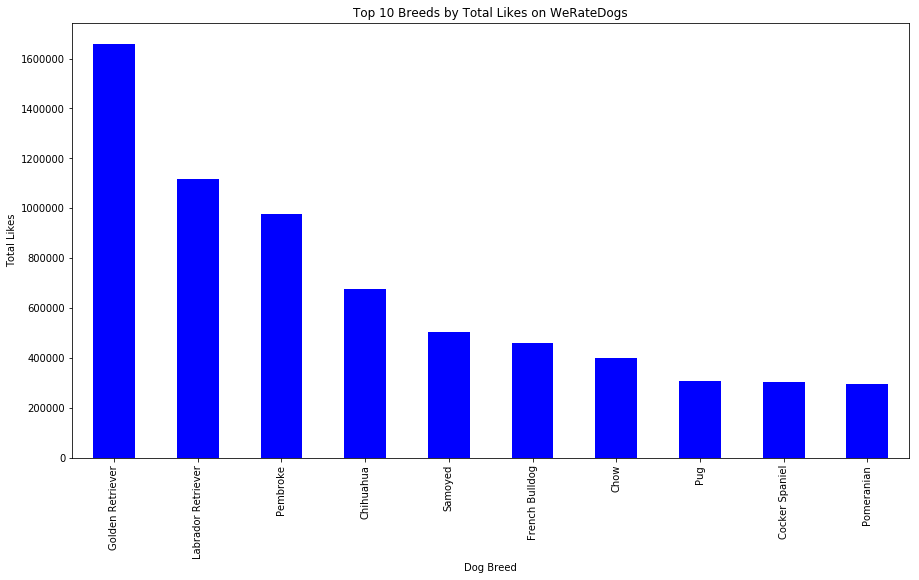

In [50]:
# Create a df where breed count is >= 10
breed_count = df_master['p1'].value_counts()
df_scores = df_master[df_master['p1'].isin(breed_count[breed_count > 8].index)]
# Plot Data
fig = plt.figure(figsize=(15,8))
df_breed_likes = df_scores.groupby('p1')['favorite_count'].sum()
df_breed_likes.sort_values(ascending=False).nlargest(10).plot(kind='bar', color='blue')
plt.title("Top 10 Breeds by Total Likes on WeRateDogs")
plt.xlabel("Dog Breed")
plt.ylabel("Total Likes")

#### 2. What stage do most dogs fall into? Pupper, Poppo, Doggo, Floofer?
For this section we will look at the percentages of dogs that fall into each of these categories, while ignoring the dogs that didn't get a classification.

From the data we can see that most dogs get classified as a pupper if they're going to be classified, the majority of dogs don't get classified.

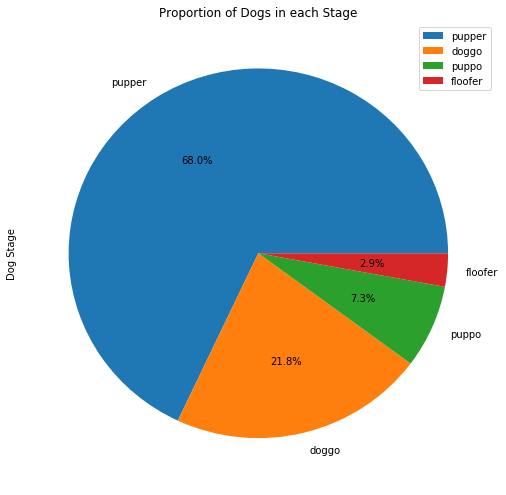

In [51]:
df_stages = df_master[df_master['dog_type'] != "None"]
fig, ax = plt.subplots(figsize=(8.5,8.5))

df_stages['dog_type'].value_counts().plot(kind = 'pie', ax = ax, label = 'Dog Stage', autopct='%1.1f%%')
plt.title('Proportion of Dogs in each Stage')
plt.legend();

#### 3. How do the breeds compare if we take into account the number of posts made for each breed?
For this section we will look at the top 10 dog breeds and determine the number of likes per post (total likes)/(total posts)

Here we can see that the Angora is the most popular, however, we can also see that we need to clean up our dog names a little bit as we have names like; Bubble, Paper Towel and Remote Control. Obviously these are not dog breeds.


Text(0,0.5,'Avg Likes')

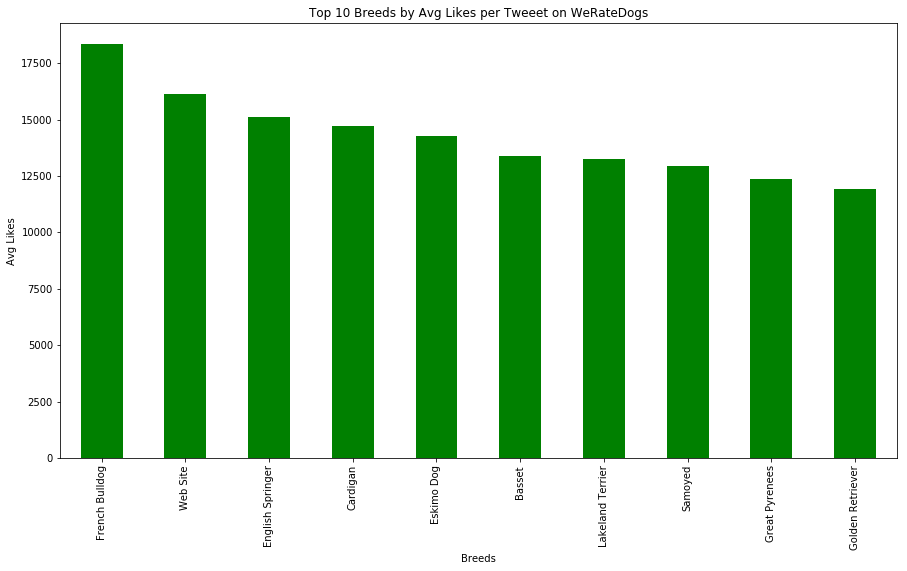

In [52]:
fig = plt.figure(figsize=(15,8))
df_breed_likes = round(df_scores.groupby('p1')['favorite_count'].sum() / df_scores.groupby('p1')['favorite_count'].count(),0)
df_breed_likes.sort_values(ascending=False).nlargest(10).plot(kind='bar', color='green')
plt.title('Top 10 Breeds by Avg Likes per Tweeet on WeRateDogs')
plt.xlabel('Breeds')
plt.ylabel('Avg Likes')

#### 4. Whats the average score given to a specific breed?
For this section we will look at the average scores given for a specific breed.

In [53]:
# Filter Out the Outliers
df_scores = df_scores[df_scores['rating_numerator'] <= 14]
df_scores.groupby('p1')['rating_numerator'].mean().sort_values(ascending=False).nlargest(20)

p1
Web Site                12.133333
Eskimo Dog              11.777778
Samoyed                 11.700000
Chow                    11.609756
Golden Retriever        11.544118
Cardigan                11.529412
Great Pyrenees          11.461538
Kelpie                  11.454545
Pembroke                11.443182
Siberian Husky          11.315789
Cocker Spaniel          11.296296
Rottweiler              11.294118
French Bulldog          11.269231
Tennis Ball             11.222222
Bernese Mountain Dog    11.200000
Pomeranian              11.189189
Old English Sheepdog    11.166667
Pekinese                11.153846
Basset                  11.153846
Kuvasz                  11.133333
Name: rating_numerator, dtype: float64

(10, 12.25)

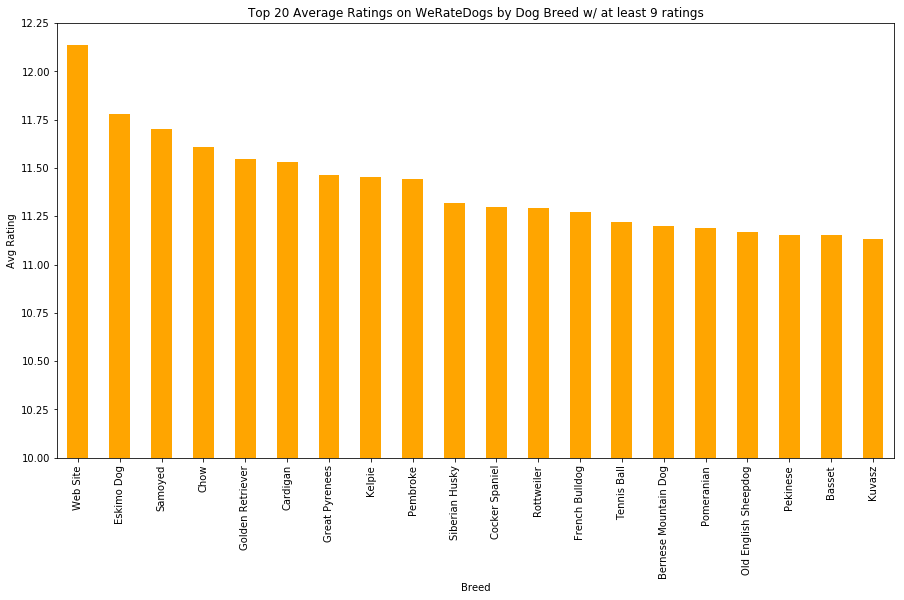

In [54]:
# Plot this data
fig = plt.figure(figsize=(15,8))
df_scores.groupby('p1')['rating_numerator'].mean().sort_values(ascending=False).nlargest(20).plot(kind='bar', color='orange')
plt.title('Top 20 Average Ratings on WeRateDogs by Dog Breed w/ at least 9 ratings')
plt.xlabel('Breed')
plt.ylabel('Avg Rating')
plt.ylim(10,12.25)